In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os

PATH_IMG = "../IMAGENS/"

PATH = os.getcwd()

print(os.getcwd())
print(os.listdir(PATH_IMG))
print(cv.__version__)

img_original = cv.imread(PATH_IMG + os.listdir(PATH_IMG)[0])
img_gray = cv.cvtColor(img_original, cv.COLOR_BGR2GRAY)

def cm_to_inch(value):
    return value/2.54

def rad_to_angle(value):
    return value*180/np.pi

def angle_to_rad(value):
    return value*np.pi/180

/home/andre/Documents/Git/VISAO_ROBOTICA_EGM0008/05_FILTRAGEM_DE_IMAGENS
['circulo.png', 'Lenna.png', 'carrinho.jpg', 'Einstein.png', 'everest.jpg', 'fabio.png']
4.10.0


# Aumento de brilho

Adição dos valores dos pixels por uma constante. Lembrando que pode dar _Overflow_ caso soma de maneira bruta, a soma deve ser o máximo e o mínimo valor dos pixels, 255 e 0 respectivamente.
<br>
<br>
A função **cv2.add(IMG, constante)** já faz essa tranbicagem.

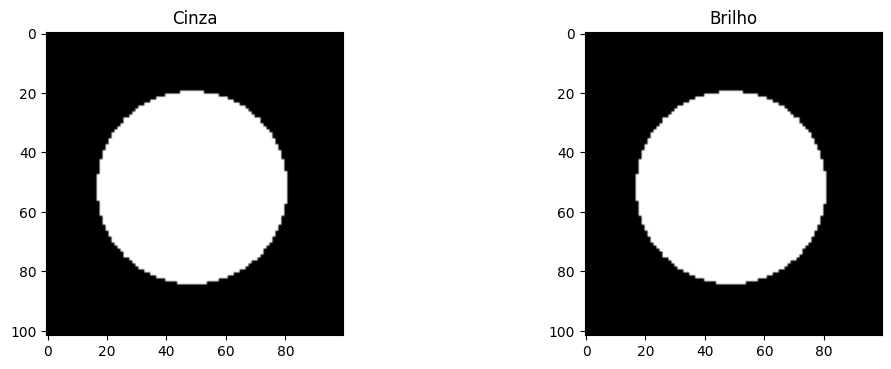

In [2]:
img_brilho = cv.add(img_gray, 100)

plt.figure(figsize=(cm_to_inch(50), cm_to_inch(10)))
plt.subplot(132), plt.imshow(img_gray, cmap='gray'), plt.title('Cinza')
plt.subplot(133), plt.imshow(img_brilho, cmap='gray'), plt.title('Brilho')
plt.show()

# Alargamento de Contraste

$ s = \frac{L}{1 + \exp^{-k \cdot (r - r_0)}}$

<br>

* $L$: Valor Máximo dos pixels;
* $k$: constante para o contraste (valor pequeno);
* $r$: Valor do pixel naquela coordenada;
* $r_0$: Valor médio da curva.

In [3]:
def Alargamento_de_contraste(img, L=255, r0=128, k=0.01):
    img_dest = np.zeros_like(img)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            img_dest[i,j] = L/(1+np.exp(-k*(np.float16(img[i,j])-r0)))
            # nao esquecer de converter o valor da img para float

    return img_dest

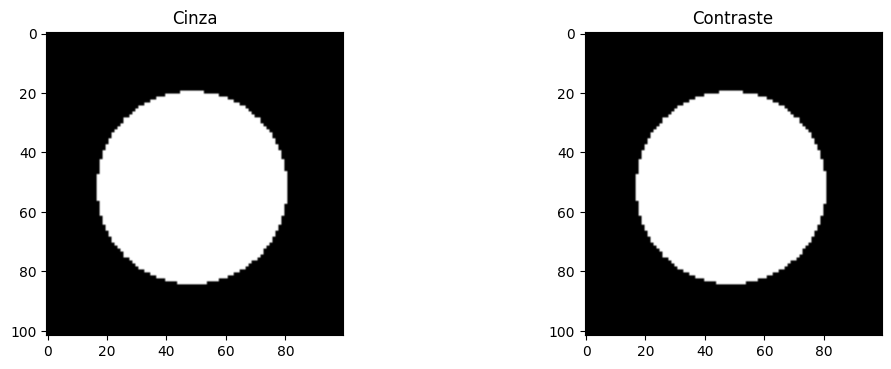

In [4]:
img_contraste = Alargamento_de_contraste(img_gray, k=0.05)

plt.figure(figsize=(cm_to_inch(50), cm_to_inch(10)))
plt.subplot(131), plt.imshow(img_gray, cmap='gray'), plt.title('Cinza')
plt.subplot(132), plt.imshow(img_contraste, cmap='gray'), plt.title('Contraste')
plt.show()

del img_contraste

# Limiarização (_Trhesholding_)

Cria uma imagem binária com base no valores dos pixels:
<br>

se $img[i][j]$ > limiar: $img[i][j] = 255$
<br>
se não: $img[i][j] = 0$

In [5]:
def thresholding(img, limiar):
    img_dest = np.zeros_like(img)

    if img_dest.ndim == 3:
        img_dest[img > limiar][:] = 255
        img_dest[img < limiar][:] = 0
    else:
        img_dest[img > limiar] = 255
        img_dest[img < limiar] = 0

    return img_dest

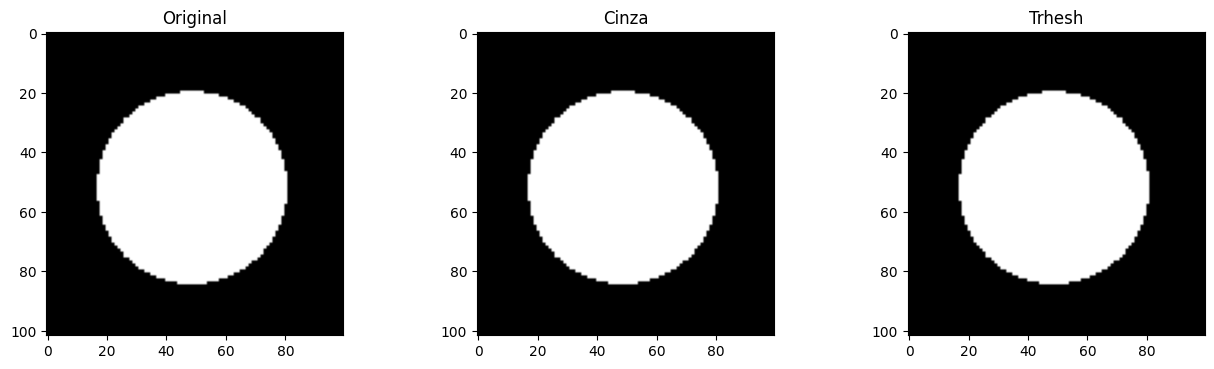

In [6]:
# img_thresh = cv.threshold(img_gray, 128, 255, cv.THRESH_BINARY)[1]

img_thresh = thresholding(img_gray, 128)

plt.figure(figsize=(cm_to_inch(40), cm_to_inch(10)))
plt.subplot(131), plt.imshow(cv.cvtColor(img_original, cv.COLOR_BGR2RGB)), plt.title('Original')
plt.subplot(132), plt.imshow(img_gray, cmap='gray'), plt.title('Cinza')
plt.subplot(133), plt.imshow(img_thresh, cmap='gray'), plt.title('Trhesh')
plt.show()

(512, 512, 3)


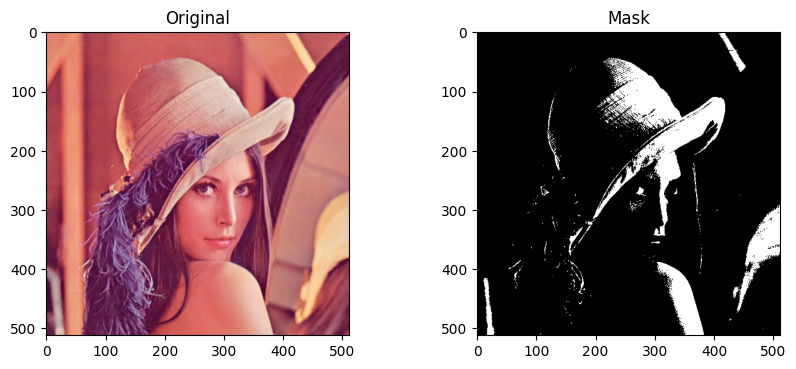

In [7]:
img_carrinho = cv.imread(PATH_IMG+os.listdir(PATH_IMG)[1])
print(img_carrinho.shape)

img_carrihno_mask = cv.inRange(img_carrinho, (150,150,128), (255,255,255))

plt.figure(figsize=(cm_to_inch(40), cm_to_inch(10)))
plt.subplot(131), plt.imshow(cv.cvtColor(img_carrinho, cv.COLOR_BGR2RGB)), plt.title('Original')
plt.subplot(132), plt.imshow(img_carrihno_mask, cmap='gray'), plt.title('Mask')

plt.show()

243.8675968782729 326.2902125071793


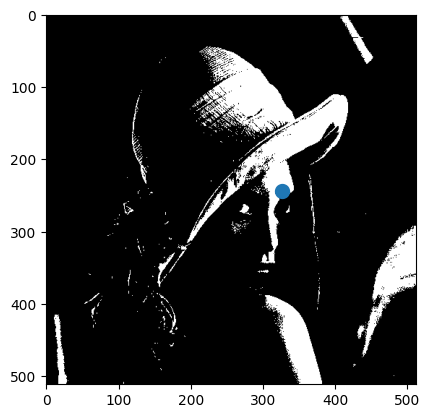

In [8]:
soma_x = 0
soma_y = 0
cont = 0
for i in range(img_carrihno_mask.shape[0]):
    for j in range(img_carrihno_mask.shape[1]):
        if img_carrihno_mask[i,j] == 255:
            soma_x += i
            soma_y += j
            cont += 1

c_x = soma_x / cont
c_y = soma_y / cont

print(c_x, c_y)

plt.imshow(img_carrihno_mask, cmap='gray')
plt.scatter(c_y, c_x, linewidths=5)

plt.show()

# Transformação Geométrica

## Warp Linear


## Warp Afim


$Imagem = A^{-1} \cdot(Imagem - b)$

* $A^{-1}$: Matriz que junta a escala com a de rotação (colocar a matriz)
* $b$: Vetor coluna $[[x],[y]]$ para realizar a translação

In [9]:
def warp(img, A, b):
    img_dest = np.zeros_like(img)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            coord = np.array([[i], [j]])
            coord_dest = np.linalg.inv(A) @ (coord - b)

            x = coord_dest[0,0]
            y = coord_dest[1,0]

            if x >= 0 and x < img.shape[0]-1 and y >= 0 and y < img.shape[1]-1:
                img_dest[i,j] = img[int(x), int(y)]

    return img_dest

(102, 100, 3)


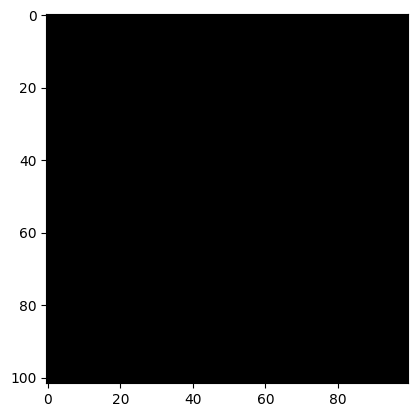

In [10]:
print(img_original.shape)

img_warp = warp(img_original, [[0.5, -0.50],[0, 0.9]], [[250],[61]])

plt.imshow(img_warp)

plt.show()

## WARP não linear

In [11]:
def warpperspective(img, M):
    img_dest = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):

            coord = np.array([[j], [i], [1]])
            coord_dest = np.linalg.inv(M) @ coord

            x,y = coord_dest[0,0] / coord_dest[2,0] , coord_dest[1,0] / coord_dest[2][0]

            if x >= 0 and x < img.shape[0]-1 and y >= 0 and y < img.shape[1]-1:
                img_dest[i,j] = img[int(y), int(x)]

    return img_dest


[[ 4.07692308e+00  0.00000000e+00 -2.46153846e+02]
 [ 1.19230769e+00  1.61538462e+00 -1.19230769e+02]
 [ 6.15384615e-03  0.00000000e+00  1.00000000e+00]]


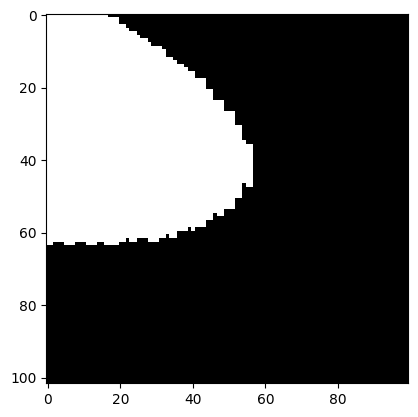

In [12]:
porigem = [[100, 100],
            [100, 400],
            [400, 400],
            [400, 100]]

pdestino = [[100, 100],
            [100, 400],
            [400, 290],
            [400, 150]]

porigem = np.float32(np.array(porigem))
pdestino = np.float32(np.array(pdestino))

H = cv.getPerspectiveTransform(porigem, pdestino)

print(H)

img_warp = warpperspective(img_original, H)
# im2 = cv.warpPerspective(img_original, H,(400, 400),flags=cv.INTER_LINEAR)

plt.imshow(cv.cvtColor(img_warp, cv.COLOR_BGR2RGB))
plt.show()



## Filtragem Linear Espacial

* A filtragem espacial também é chamada de correlação espacial.

* Fazer a correlação da máscara, ou filtro, $w$ com uma imagem $I$ é
representado por:

![Espacial](../imgs_markdown/espacial.jpg)

In [13]:
def filtro_espacial(img, kernel):
    img_temp = np.zeros_like(img, dtype=np.float16)

    lk = kernel.shape[0]
    ck = kernel.shape[1]

    llin = int(lk/2)
    lcol = int(ck/2)

    res = 0
    for i in range(llin, img.shape[0] - llin):
        for j in range(lcol, img.shape[1] - lcol):
            janela = img[(i-llin):(i+llin+1), (j-lcol):(j+lcol+1)]
            res = janela * kernel

            img_temp[i,j] = np.sum(res)

    return img_temp

### Filtro da Média dos Vizinhos

Deixa a imagem mais suavizada, porém borra a imagem na direção
perpendicular

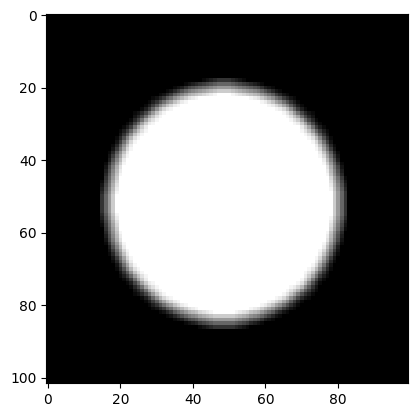

In [14]:
n = 5
kernel = 1/n**2 * np.ones((n,n))

plt.imshow(filtro_espacial(img_gray, kernel), cmap='gray')
plt.show()

### Gaussinao

Mesma função da média, porém distorce menos a imagem

In [15]:
def gaussian_kernel(size, k, sigma):
    kernel = np.zeros((size,size))
    
    llin = int(size/2) #supoe impar
    lcol = llin #e quadrado
    
    for m in range(-llin, llin+1):
        for n in range(-lcol, lcol+1):
            kernel[m+llin, n+lcol] = k*np.exp(-(m**2+n**2) / (2*sigma**2))
    
    kernel = 1 / np.sum(kernel) * kernel 
    
    return kernel

[[0.07511361 0.1238414  0.07511361]
 [0.1238414  0.20417996 0.1238414 ]
 [0.07511361 0.1238414  0.07511361]]
0.9999999999999997


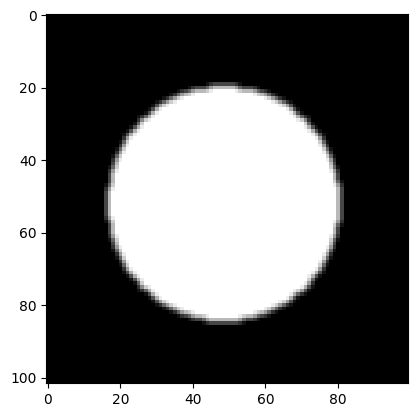

In [16]:
kernel_gaussiano = gaussian_kernel(3, 1, 1)

print(kernel_gaussiano)
print(np.sum(kernel_gaussiano))

img_gaussiano = filtro_espacial(img_gray, kernel_gaussiano)

plt.imshow(img_gaussiano, cmap="gray")

plt.show()

### Filtro Laplaciano

Irá produzir valores altos
para regiões com mudanças abruptas e
valores baixos para regiões calmas

O resultado irá conter valores
negativos, portanto devemos criar uma
imagem com tipo inteiro ou
preferencialmente float para guarda-los

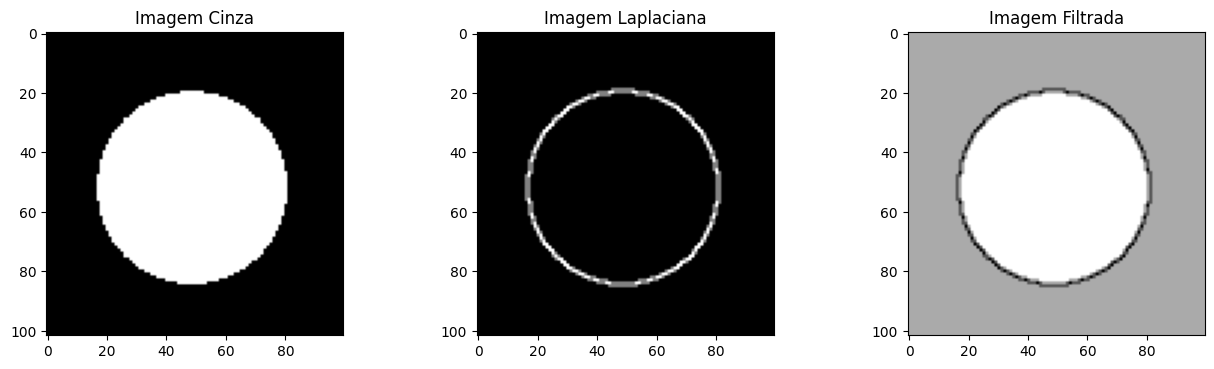

In [17]:
kernel_laplaciano = np.array([
    [0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]
])

img_laplaciano = np.abs(filtro_espacial(img_gray, kernel_laplaciano))

img_filtrada = img_gray - img_laplaciano

plt.figure(figsize=(cm_to_inch(40), cm_to_inch(10)))
plt.subplot(131)
plt.title("Imagem Cinza")
plt.imshow(img_gray, cmap='gray')

plt.subplot(132)
plt.title("Imagem Laplaciana")
plt.imshow(img_laplaciano, cmap='gray')

plt.subplot(133)
plt.title("Imagem Filtrada")
plt.imshow(img_filtrada, cmap='gray')

plt.show()

del img_filtrada, img_laplaciano

### Filtro Sobel

Realça as bordas dependendo da orientação do kernel. Podendo ser horizontal
ou vertical.

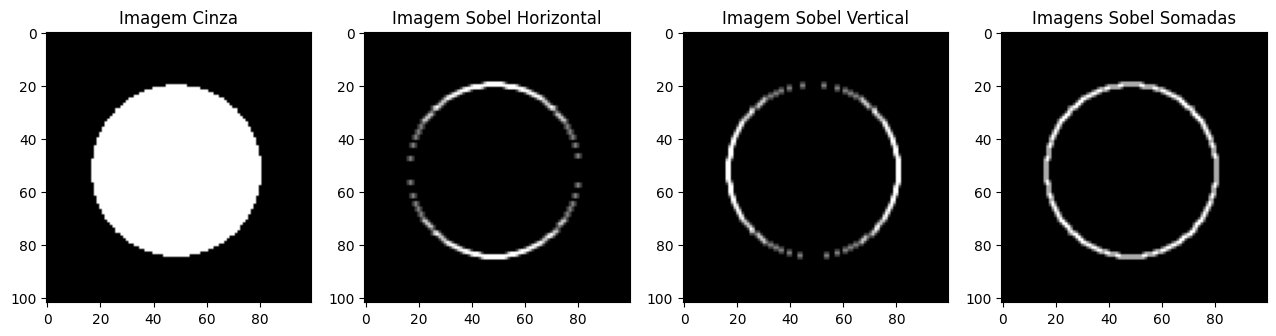

In [ ]:
kernel_sobel_horizontal = np.array([
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]
])

kernel_sobel_vertical = kernel_sobel_horizontal.transpose()

img_sobel_horizontal = np.abs(filtro_espacial(img_gray, kernel_sobel_horizontal))
img_sobel_vertical = np.abs(filtro_espacial(img_gray, kernel_sobel_vertical))

img_sobel_soma = img_sobel_horizontal + img_sobel_vertical

plt.figure(figsize=(cm_to_inch(40), cm_to_inch(40)))
plt.subplot(141)
plt.title("Imagem Cinza")
plt.imshow(img_gray, cmap='gray')

plt.subplot(142)
plt.title("Imagem Sobel Horizontal")
plt.imshow(img_sobel_horizontal, cmap='gray')
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os

plt.subplot(143)
plt.title("Imagem Sobel Vertical")
plt.imshow(img_sobel_vertical, cmap='gray')

plt.subplot(144)
plt.title("Imagens Sobel Somadas")
plt.imshow(img_sobel_soma, cmap='gray')

plt.show()

#### Ângulos

Gradiente de mudança dos pixels

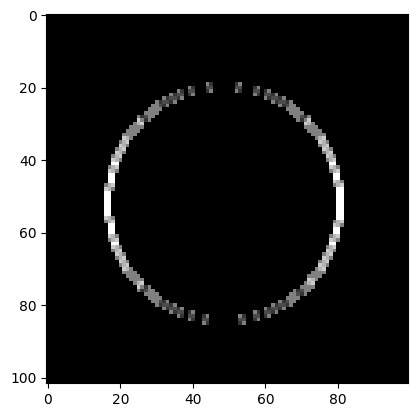

In [19]:
img_gradiente = np.arctan2(img_sobel_vertical, img_sobel_horizontal)
img_gradiente = rad_to_angle(img_gradiente) + 90.

plt.imshow(img_gradiente, cmap='gray')

plt.show()

del img_sobel_horizontal, img_sobel_vertical, img_sobel_soma, img_gradiente